In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

In [27]:
def prepare_data(dataframe: pd.DataFrame):
    # Features to del
    features_to_del = ['Perimeter', 'MajorAxisLength', 
                       'MinorAxisLength', 'ConvexArea', 
                       'EquivDiameter', 'AspectRation', 
                       'Eccentricity', 'ShapeFactor3'
                       ]

    abod_detector = ABOD(contamination=0.05, n_neighbors=20, method='fast')
    outliers = abod_detector.fit_predict(dataframe.drop(["Class"], axis=1).to_numpy())
    df_with_detected_outliers = pd.concat([dataframe, pd.DataFrame(outliers, columns=["is_outlier"])], axis=1)
    df_cleaned = df_with_detected_outliers[df_with_detected_outliers["is_outlier"] == 0]
    df_cleaned = df_cleaned.drop(features_to_del, axis=1).drop(["is_outlier"], axis=1)

    return df_cleaned

In [28]:
df = pd.read_excel("../../data/Dry_Bean_Dataset.xlsx")
df_cleaned = prepare_data(df)
df_cleaned.head()

/Users/nikolajfonov/Programming/GitRepositories/comparison-of-bayesian-classifiers/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


,Area,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,28395,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.998724,SEKER
1,28734,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.998430,SEKER
2,29380,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.999066,SEKER
3,30008,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.994199,SEKER
4,30140,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.999166,SEKER


In [55]:
x = df_cleaned.drop(["Class"], axis=1).to_numpy()
y = df_cleaned["Class"].to_numpy()
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear"]

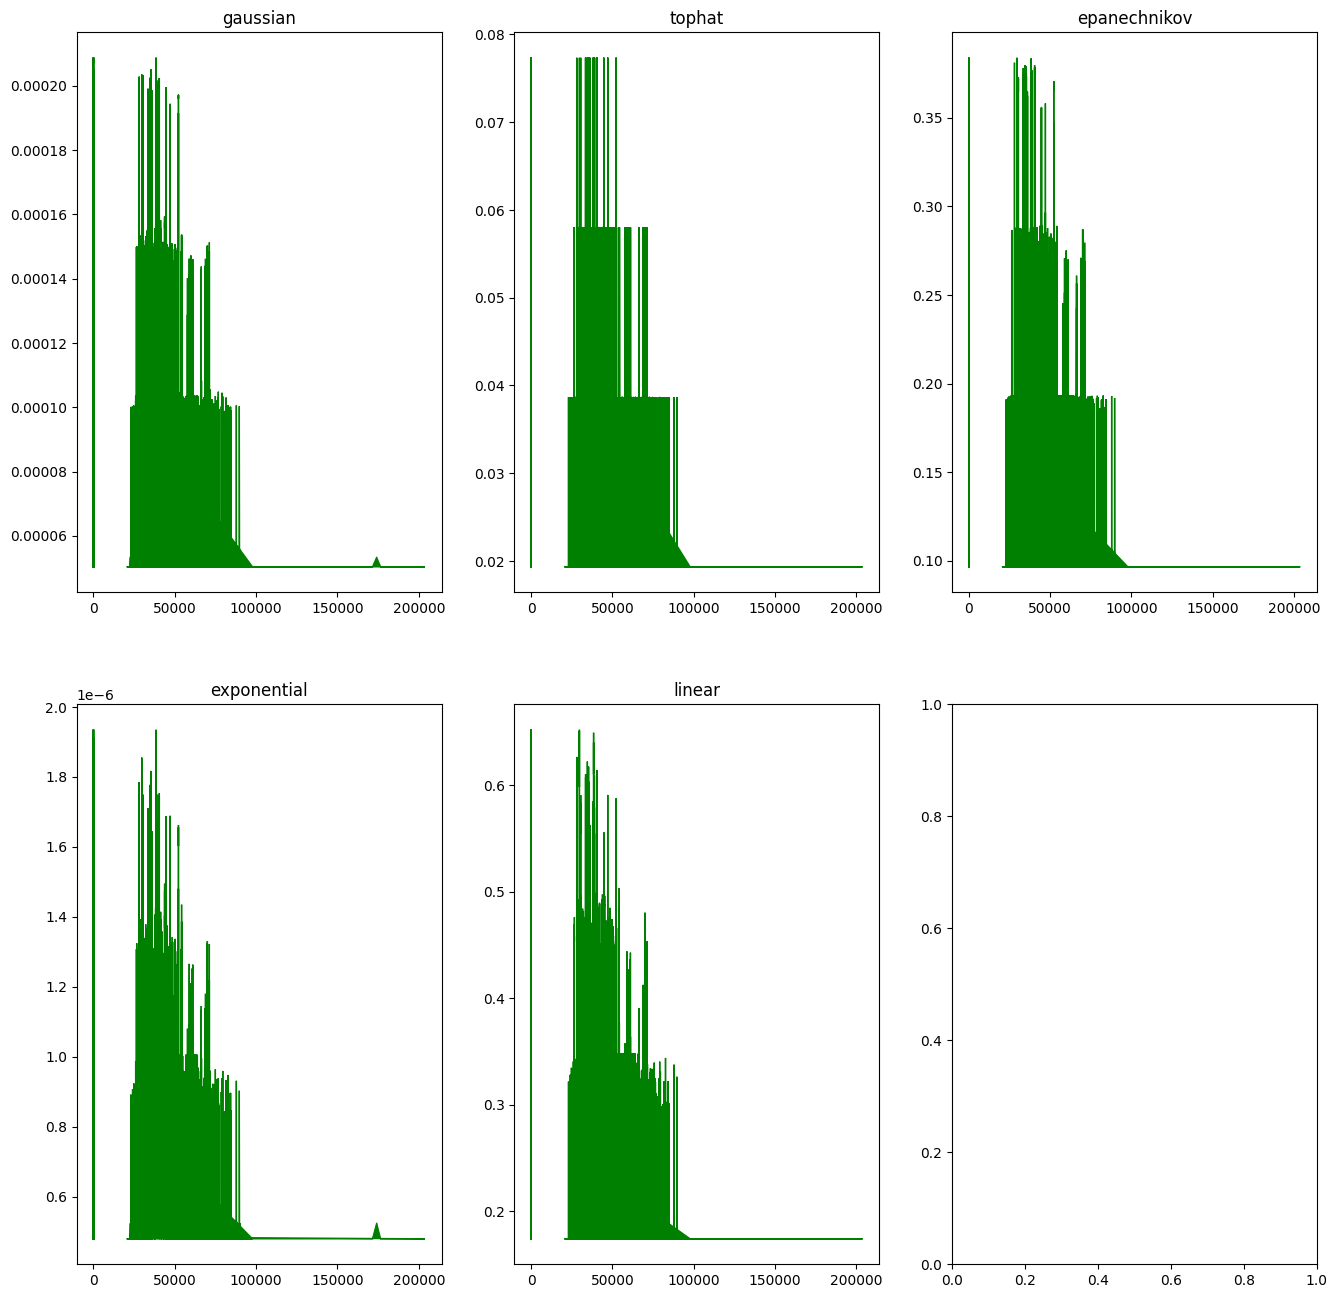

In [57]:
def plot_distribution_kernel(kernels):
    fig, ax = plt.subplots(2, 3, figsize=(16, 16))
    for i, kernel in enumerate(kernels):
        
        kde = KernelDensity(kernel=kernel, bandwidth="silverman").fit(x)
        log_dens = kde.score_samples(x)
        #print(i // 3, i % 3)
        ax[i // 3][i % 3].fill(x, np.exp(log_dens), c='green')
        ax[i // 3][i % 3].set_title(kernel)
    plt.show()

plot_distribution_kernel(kernels=kernels)

In [81]:
from sklearn.metrics import accuracy_score

def get_std_mean(kernels):
    res_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for i, (train_index, test_index) in enumerate(kf.split(x)):
            kde = KernelDensity(kernel=kernel, bandwidth="silverman").fit(x)
            dens = np.exp(kde.score_samples(x)).reshape((-1, 1))
            gnb = GaussianNB().fit(dens[train_index], y[train_index])
            res_dict[kernel].append(accuracy_score(gnb.predict(dens[test_index]), y[test_index]))
    return res_dict

res = get_std_mean(kernels=kernels)

In [82]:
pd.DataFrame(res).describe().loc[["mean", "std"]]

,gaussian,tophat,epanechnikov,exponential,linear
mean,0.158082,0.069838,0.071926,0.262800,0.073318
std,0.011327,0.008298,0.007273,0.020236,0.006270


In [89]:
def get_std_mean(kernels, bandwith):
    res_mean_dict = {kernel: [] for kernel in kernels}
    res_std_dict = {kernel: [] for kernel in kernels}
    kf = KFold(n_splits=10, shuffle=True)
    for kernel in kernels:
        for bw in bandwith:
            bw_res = []
            for i, (train_index, test_index) in enumerate(kf.split(x)):
                kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(x)
                dens = np.exp(kde.score_samples(x)).reshape((-1, 1))
                gnb = GaussianNB().fit(dens[train_index], y[train_index])
                bw_res.append(accuracy_score(gnb.predict(dens[test_index]), y[test_index]))
            res_mean_dict[kernel].append(np.mean(bw_res))
            res_std_dict[kernel].append(np.std(bw_res))
    return res_mean_dict, res_std_dict

to_test = [0.5, 1, 2, 4, 8, 16]
res = get_std_mean(kernels=kernels, bandwith=to_test)

In [118]:
def plot_bandwith_cmp(bandwiths, bandwiths_values, name):
    fig, ax = plt.subplots(2, 3, figsize=(16, 16))
    fig.suptitle(name, fontsize=20)
    for i, bandwith in enumerate(bandwiths.keys()):
        ax[i // 3][i % 3].plot(bandwiths_values, bandwiths[bandwith], c='green')
        ax[i // 3][i % 3].set_title(bandwith)
    
    plt.show()

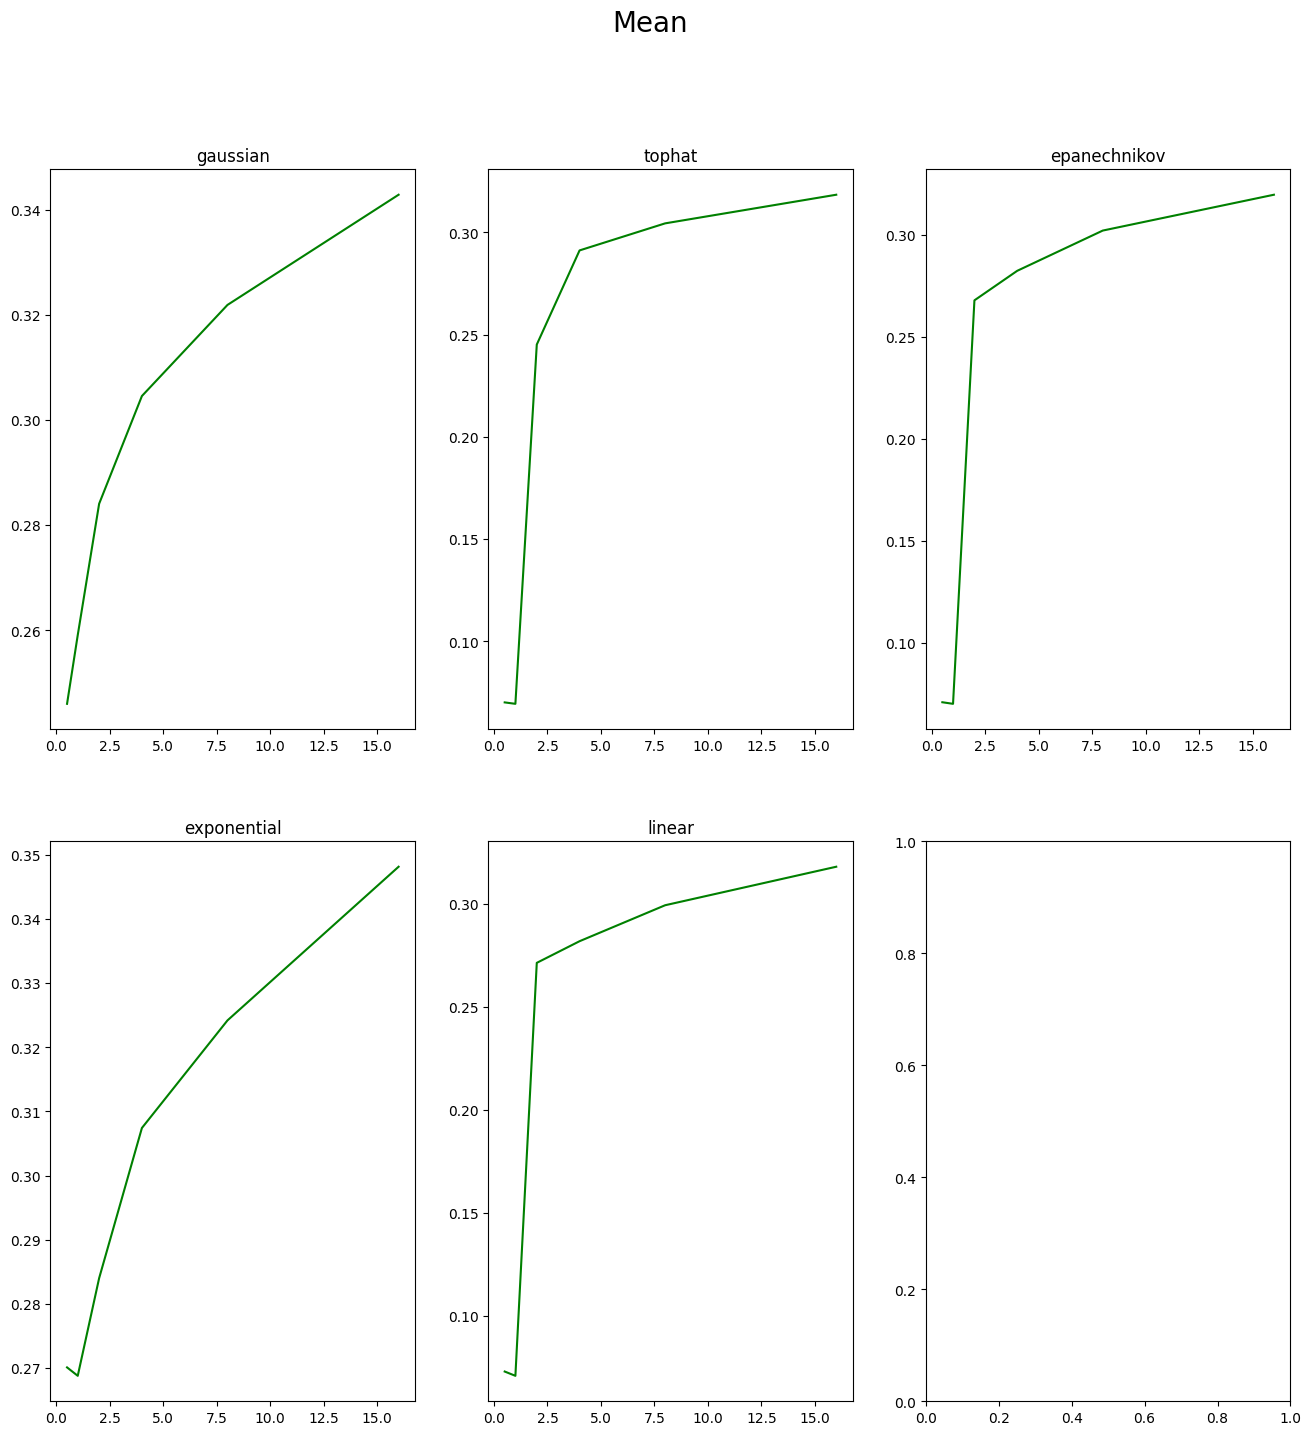

In [119]:
# Mean bandwith
to_test = [0.5, 1, 2, 4, 8, 16]
plot_bandwith_cmp(res[0], to_test, "Mean")

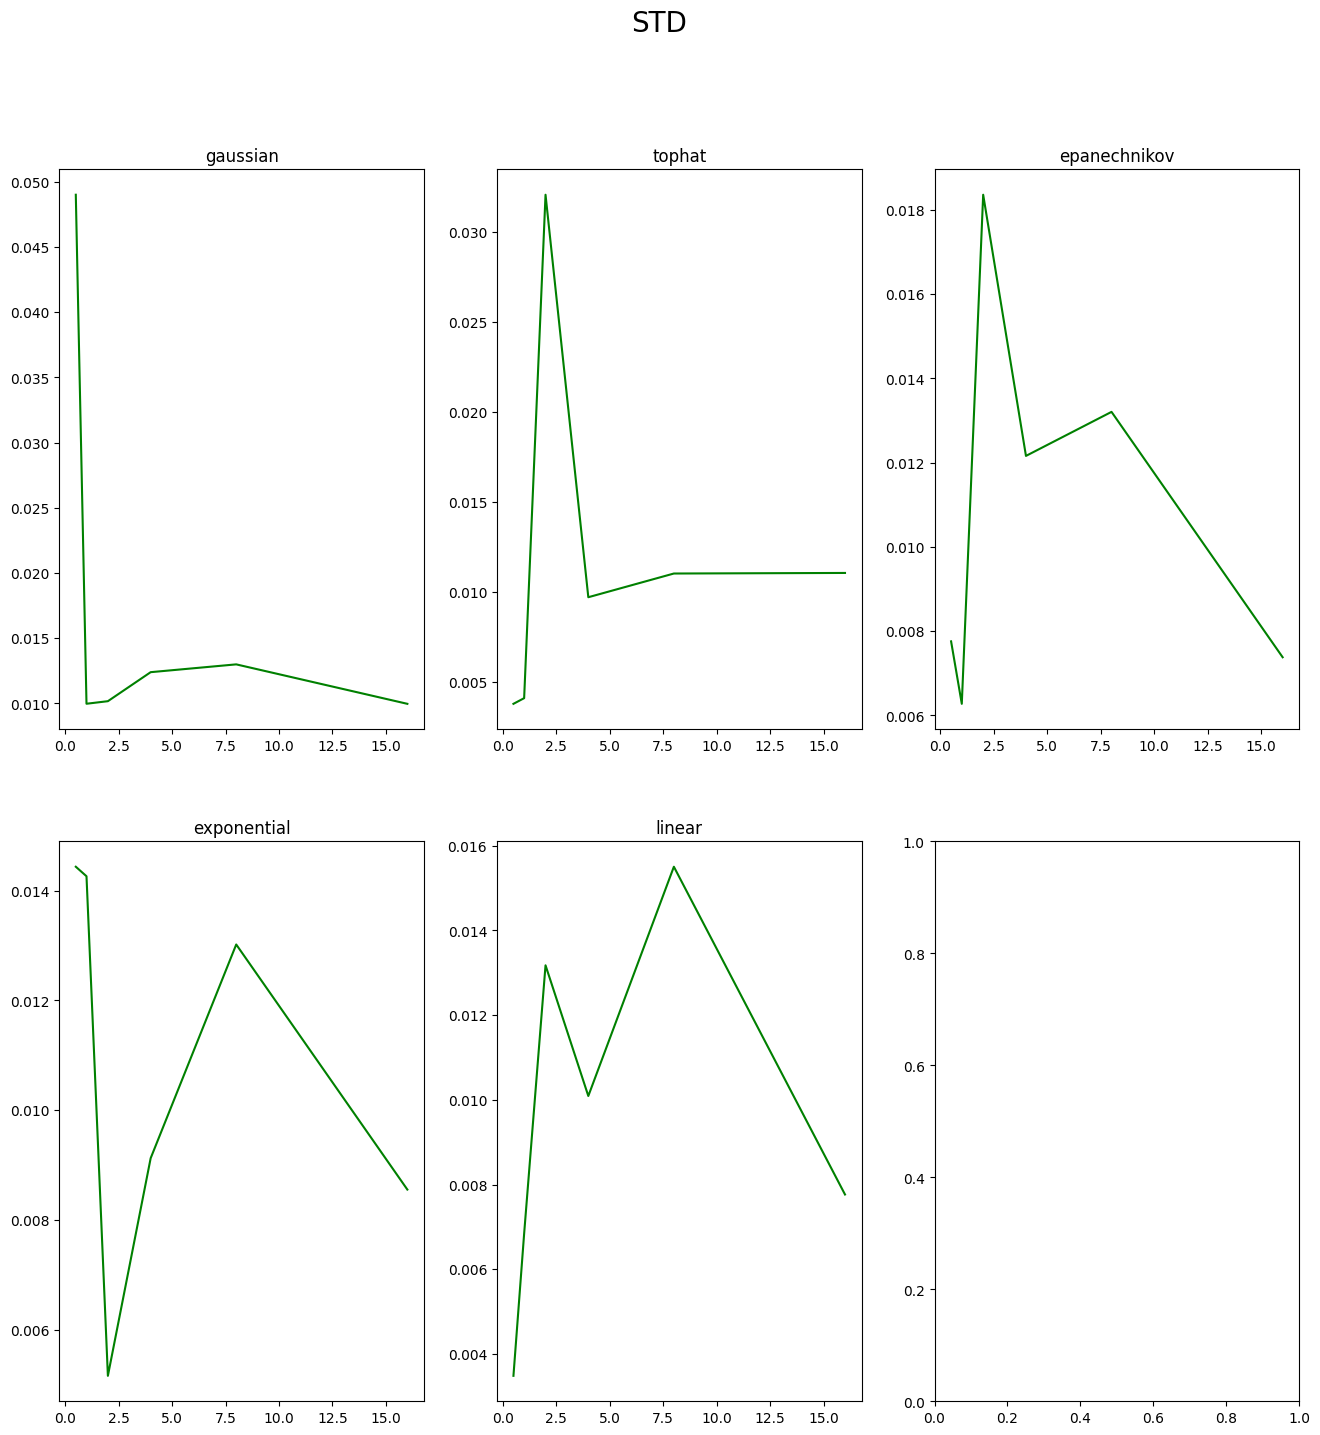

In [120]:
# STD bandwith
to_test = [0.5, 1, 2, 4, 8, 16]
plot_bandwith_cmp(res[1], to_test, "STD")

The classifier has the greatest generalizing function when the window width is equal to 16

array([5, 5, 5, ..., 3, 3, 3])